# Striated fiber orientation -  Alignment by Fourier Transform (AFT)

The code used is adjusted from https://github.com/OakesLab/AFT-Alignment_by_Fourier_Transform developed by the Oakes lab. A maximum projection image of either the ventral or dorsal surface of the striated fiber channel, skeletonized using ImageJ, is imported (ExM image). In a few words, the image is split in windows of a given size and within each of them the Fourier transform is calculated after resolving problems from their edges. In Fourier space, by calculating different moments the slope corresponding to the filament orientation is found along with the eccentricity. The results are plotted along with an overlay of the detected filaments per window on the original image.

**Input:**

*file_path*    :    The path to the tif file of a max projection of the striated fiber channel, expansion microscopy images are used

*pixel_size*   :    The pixel size in microns (can be found in ImageJ after opening the tiff with ctrl+shift+P and checking the width and height values)

*window_size_microns* : choose an appropriate window size to capture the fibers but not to have issues with noise

Within the aft_2d_projection definition, the parameters can also be adjusted: 

*overlap*             :  If set to 1 the windows do not overlap. Below 1 and towards 0 the overlap increases

*intensity_thresh*    :  To minimize background noise adjust a cut-off threshold of image intensity

*eccentricity_thresh* :  Adjust to improve the detection or remove artifacts


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.morphology import disk
import numpy.matlib as matlib
from scipy.fft import fft2, fftshift, ifft2, ifftshift, fft, ifft, fftfreq
import tifffile
import matplotlib as mpl

# Ensure text is saved as editable text in SVG
mpl.rcParams['svg.fonttype'] = 'none'
# Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

In [2]:
# # Interactive Plotting
%matplotlib widget 

In [3]:
def aft_2d_projection(image, pixel_size, window_size, overlap = 0.5,intensity_thresh = 0.8, eccentricity_thresh = 0.4, visualize_results = True):
    """ 
    Alignment by Fourier Transform (AFT):
    The following function calculates the local angles and eccentricities for a filamentous network.
    Input is the 2D max projection of a confocal z-stack of the striated fiber channel (ExM image).
    Note: follows the approach of: https://github.com/OakesLab/AFT-Alignment_by_Fourier_Transform
    """
    im_aft = image#.to_numpy()
    N_aft_rows, N_aft_cols = im_aft.shape
    
    # make window size off number if it isn't already
    if window_size % 2 == 0:
        window_size += 1
    # define the radius of the window
    radius = int(np.floor((window_size) / 2))

    # make a list of the rows and columns positions for the windows:
    rpos = np.arange(radius,N_aft_rows-radius,int(window_size * overlap))
    cpos = np.arange(radius,N_aft_cols-radius,int(window_size * overlap))

    # make a structuring element to filter the mask
    bpass_filter = disk(radius * .5)
    # make window mask
    window_mask = np.zeros((window_size, window_size))
    window_mask[int(np.floor(window_size/2)), int(np.floor(window_size/2))] = 1

    # filter the mask with the structuring element to define the ROI
    window_mask = cv2.filter2D(window_mask, -1, bpass_filter)
    window_mask = np.rint(window_mask) == 1

    im_mask = np.ones_like(im_aft).astype('bool')
    
    # make x and y coordinate matrices (for window)
    xcoords, ycoords = np.meshgrid(np.arange(0,window_size) , np.arange(0,window_size))
    # length of displaying orientation vector
    arrow_length = radius / 2
    
    # make empty arrays
    im_theta = np.array([])
    im_ecc = np.array([])
    x, y = [], []
    u = np.array([])
    v = np.array([])
    
    for r in rpos:
        for c in cpos:        
            # store the row and column positions
            x.append(c)
            y.append(r)
            # check to see if point is within image mask
            if im_mask[r,c] == True:
                # define the window to analyze
                im_window = im_aft[r-radius:r+radius+1,c-radius:c+radius+1]
                # check that it's above the intensity threshold
                if np.mean(im_window) > intensity_thresh:
                    #### periodic decomposition:
                    im_window = im_window.astype('float32')
                    # find the number of rows and cols
                    N_rows, N_cols = im_window.shape
                    # create an zero matrix the size of the image
                    fix_borders = np.zeros((N_rows,N_cols))
                    # deal with edge discontinuities
                    fix_borders[0,:] = im_window[0,:] - im_window[-1,:]
                    fix_borders[-1,:] = -fix_borders[0,:]
                    fix_borders[:,0] = fix_borders[:,0] + im_window[:,0] - im_window[:,-1]
                    fix_borders[:,-1] = fix_borders[:,-1] - im_window[:,0] + im_window[:,-1]
                    # calculate the frequencies of the image
                    fx = matlib.repmat(np.cos(2 * np.pi * np.arange(0,N_cols) / N_cols),N_rows,1)
                    fy = matlib.repmat(np.cos(2 * np.pi * np.arange(0,N_rows) / N_rows),N_cols,1).T
                    # set the fx[0,0] to 0 to avoid division by zero
                    fx[0,0] = 0
                    ## calculate the smoothed image component
                    # 0.5 / (2 - fx - fy): filter applied in frequency domain to emphasize low-frequency components 
                    # and de-emphasizing high-frequency component
                    im_window_smooth = np.real(ifft2(fft2(fix_borders) * 0.5 / (2 - fx - fy)))
                    im_window_periodic = im_window - im_window_smooth
                    
                    # take the FFT of the periodic component
                    im_window_fft = fftshift(fft2(im_window_periodic))
                    
                    # find the image norm and mulitply by the mask
                    im_window_norm = np.sqrt(np.real(im_window_fft * np.conj(im_window_fft)))
                    im_window_fft_norm = im_window_norm * window_mask
                    N_rows, N_cols = im_window_fft_norm.shape
                    
                    #calculate the moments
                    # zero-order moment represents the total intensity (or mass) of the image
                    M00 = np.sum(im_window_fft_norm)
                    # first-order moments are used to find the centroid (center of mass)
                    # weighted sum of the pixel coordinates
                    M10 = np.sum(im_window_fft_norm * xcoords)
                    M01 = np.sum(im_window_fft_norm * ycoords)
                    # second-order moments: spread and orientation of the image
                    # correlation between x and y
                    M11 = np.sum(im_window_fft_norm * xcoords * ycoords)
                    # variance in x direction
                    M20 = np.sum(im_window_fft_norm * xcoords * xcoords)
                    # variance in y direction
                    M02 = np.sum(im_window_fft_norm * ycoords * ycoords)
                    
                    # center of mass
                    xave = M10 / M00
                    yave = M01 / M00
    
                    # calculate the central moments
                    mu20 = M20/M00 - xave**2
                    mu02 = M02/M00 - yave**2
                    mu11 = M11/M00 - xave*yave
                    
                    # angle of axis
                    theta = 0.5 * np.arctan2((2 * mu11),(mu20 - mu02))
    
                    # multiply by -1 to correct for origin being in top left corner instead of bottom right
                    theta = -1 * theta
                    
                    # find eigenvectors of covariance matrix
                    lambda1 = (0.5 * (mu20 + mu02)) + (0.5 * np.sqrt(4 * mu11**2 + (mu20 - mu02)**2))
                    lambda2 = (0.5 * (mu20 + mu02)) - (0.5 * np.sqrt(4 * mu11**2 + (mu20 - mu02)**2))
        
                    # calculate the eccentricity (e.g. how oblong it is)
                    eccentricity = np.sqrt(1 - lambda2/lambda1)
                    
                    # # correct for real space
                    # theta = theta + np.pi/2
    
                    # # map everything back to between -pi/2 and pi/2
                    # if theta > np.pi/2:
                    #     theta -= np.pi

                    # Adjust orientation to be relative to the y-axis
                    theta = -theta

                    # Map everything back to between -pi/2 and pi/2
                    if theta > np.pi/2:
                        theta -= np.pi
                    elif theta < -np.pi/2:
                        theta += np.pi
                        
                    # filter based on eccentricity
                    if eccentricity < eccentricity_thresh:
                        eccentricity = np.nan
                        theta = np.nan
    
                    # add the values 
                    im_theta = np.append(im_theta, theta)
                    im_ecc = np.append(im_ecc, eccentricity)
                    u = np.append(u, np.cos(theta) * arrow_length)
                    v = np.append(v, np.sin(theta) * arrow_length)
                else:
                    im_theta = np.append(im_theta, np.nan)
                    im_ecc = np.append(im_ecc, np.nan)
                    u = np.append(u, np.nan)
                    v = np.append(v, np.nan)
    x = np.array(x)
    y = np.array(y)        
    im_theta = np.reshape(im_theta,(len(rpos),len(cpos)))
    im_ecc = np.reshape(im_ecc,(len(rpos),len(cpos)))

    # Save the array of angles in degrees to a csv file and as a binary .npy file
    np.savetxt(save_path + image_name[:-4] + "_angles_in_degrees.csv", im_theta * 180 / np.pi, delimiter=",", fmt="%.6f")
    np.savetxt(save_path + image_name[:-4] + "_angles_in_degrees.txt", im_theta * 180 / np.pi, fmt="%.6f")
    np.save(save_path + image_name[:-4] + "_angles_in_degrees.npy", im_theta * 180 / np.pi)
    
    # visualization:
    if visualize_results == True:

        # To get the angle:
        plt.figure(facecolor='white')
        plt.imshow(im_theta * 180 / np.pi, vmin=-90, vmax=90, aspect=1, cmap='twilight_shifted')
        plt.colorbar()
        plt.axis('off')
        plt.grid(False)
        plt.title('Orientation:' + str(round(np.nanmean(np.abs(im_theta) * 180 / np.pi),3)) + " +/- " +  str(round(np.std(np.abs(im_theta) * 180 / np.pi),3))  )

        print("angle (degrees)            : ", np.nanmean(np.abs(im_theta) * 180 / np.pi))
        print("error in angle (degrees)   : ", np.nanstd(np.abs(im_theta) * 180 / np.pi))
        # plt.savefig(save_path + "w_s_" + str(window_size)+ '_angle_map.tif' , format='png', dpi=300)
        plt.savefig(save_path + image_name[:-4] + "_w_s_" + str(window_size_microns)+ '_angle_map.tif' , format='png', dpi=300)
        plt.savefig(save_path + image_name[:-4] + "_w_s_" + str(window_size_microns)+ '_angle_map.svg' , format='svg', dpi=300)


        plt.figure()
        plt.imshow(im_ecc, vmin=0, vmax=1, aspect=1,)
        plt.colorbar()
        plt.title('Eccentricity:' + str(round(np.nanmean(im_ecc),3)) + " +/- " +  str(round(np.std(im_ecc),3))  )

        print("eccentricity               : ", np.nanmean(im_ecc))
        print("error in eccentricity      : ", np.nanstd(im_ecc))

        # plt.savefig(save_path + "w_s_" + str(window_size)+ '_eccentrcitiy_map.tif', format='png', dpi=300)
        plt.savefig(save_path + image_name[:-4] + "_w_s_" + str(window_size_microns)+ '_eccentrcitiy_map.tif', format='png', dpi=300)


        plt.figure()
        plt.imshow(im_aft, cmap='Greys_r')
        # plt.quiver(x,y,u,v, color='yellow', pivot='mid', scale_units='xy', scale=overlap/2, headaxislength=0, headlength=0, width=0.001)
        plt.quiver(x,y,v,u, color='yellow', pivot='mid', scale_units='xy', scale=overlap/2, headaxislength=0, headlength=0, width=0.001)
        plt.title('Overlay')


        # plt.savefig(save_path + "w_s_" + str(window_size)+ '_overlay.tif', format='png', dpi=300)
        plt.savefig(save_path + image_name[:-4] + "-w_s_" + str(window_size_microns)+ '_overlay.tif', format='png', dpi=300)

    return 



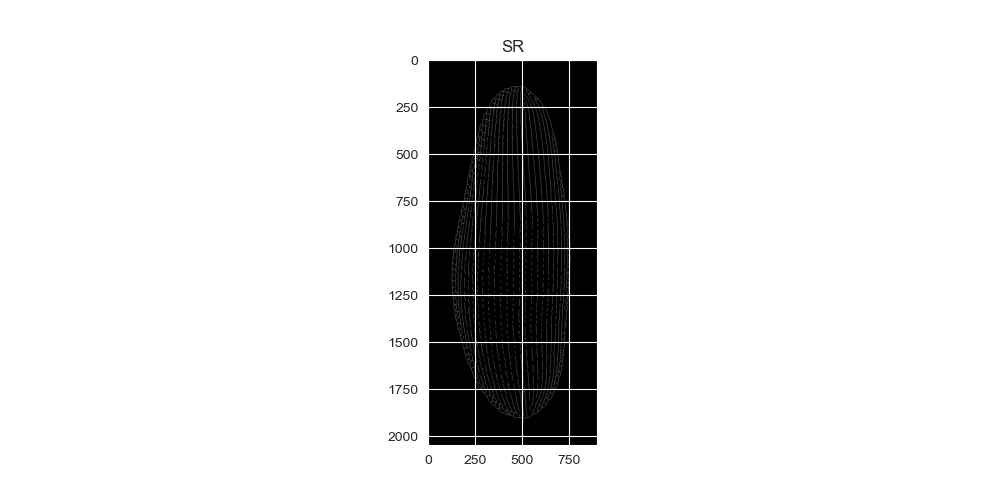

In [8]:
image_name = "MAX_ExM_ptetWT_SR_cell12_dorsal_SR_mask_skeleton.tif"

image_folder = "W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Maximum projections\\"
image_path = image_folder + image_name
save_path = "W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Orientation Results SR\\"


image  = tifffile.imread(image_path)

pixel_size = 0.288 / 4.23 # microns

plt.figure(figsize=(10, 5))
plt.title('SR')
plt.imshow(image, cmap='gray')
plt.show()

In [9]:
# # Normalize the image to the range [0, 1]
# image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
#
# # Apply brightness scaling, if needed
# brightness_factor = 5
# image_brightened = np.clip(image_normalized * brightness_factor, 0, 1)
#
# # Display the brighter image
# plt.figure(figsize=(10, 5))
# plt.title('SR - Brightened Image')
# plt.imshow(image_brightened, cmap='gray')
# plt.show()

angle (degrees)            :  8.184366369047835
error in angle (degrees)   :  11.007315946056837
eccentricity               :  0.773216172235638
error in eccentricity      :  0.10172915464187879


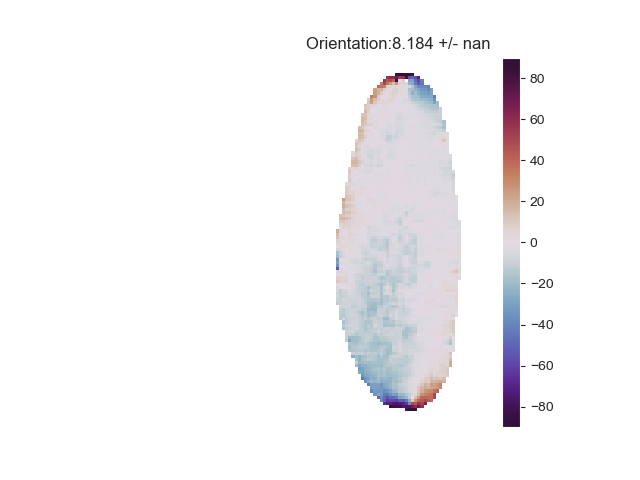

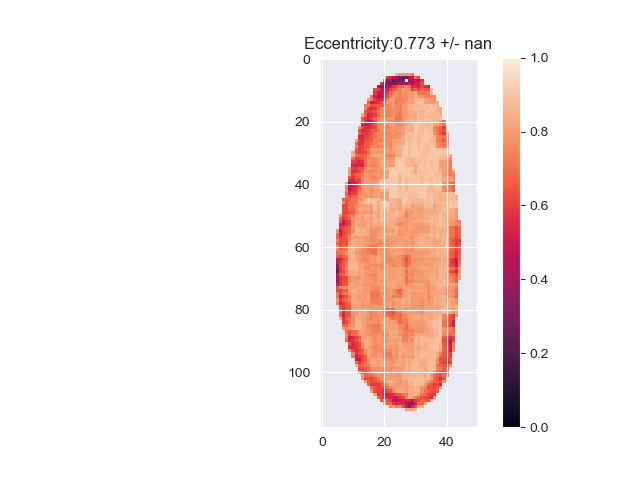

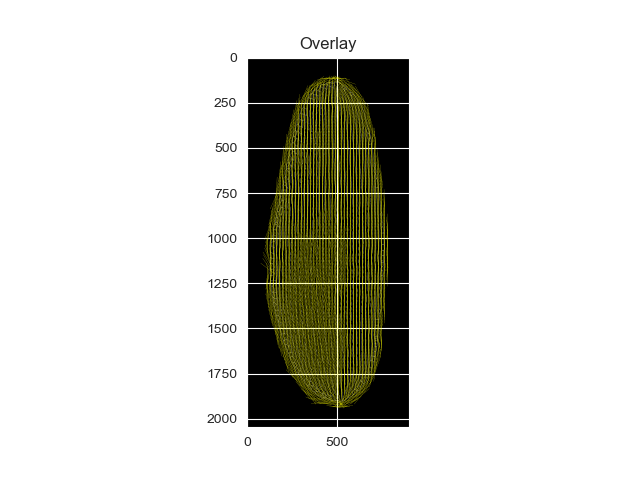

In [11]:
window_size_microns = 4
window_size_pixel = int(window_size_microns/pixel_size)
# aft_2d_projection(image_brightened*256, pixel_size, window_size_pixel, overlap = 0.5,intensity_thresh = 0.8, eccentricity_thresh = 0.4, visualize_results = True)
aft_2d_projection(image, pixel_size, window_size_pixel, overlap = 0.3,intensity_thresh = 0.9, eccentricity_thresh = 0.2, visualize_results = True)
# aft_2d_projection(image, pixel_size, window_size_pixel, overlap = 0.3,intensity_thresh = 0.9, eccentricity_thresh = 0.3, visualize_results = True)